# Introduction

---



This notebook presents an implementation of an analysis method for detecting and understanding artefacts in NLP datasets, specifically the Stanford Natural Language Inference (SNLI) dataset. This analysis is based on the research paper titled **"Competency Problems: On Finding and Removing Artifacts in Language Data"**.

In NLP tasks, datasets often contain subtle biases or artefacts that models may exploit to make predictions. These biases aren't always evident upon cursory inspection and may lead to overestimated performance metrics as models rely on them rather than learning the intended linguistic phenomena.

The research paper this notebook refers to proposes a method for detecting these dataset artefacts using statistical techniques. **The approach is grounded on the calculation of Z-statistics for each token in the dataset, considering each label. A token with a Z-statistic that significantly deviates from what we would expect under a null hypothesis is considered a potential artefact.**

***This notebook covers the process of loading and preprocessing the dataset, calculating token statistics, and using these statistics to identify potential artefacts.*** It also provides a visualization of these artefacts, offering insights into how they distribute across different labels in the dataset.


---

---
Artefacts Graph from the Paper</br>
![Artefacts Graph from the Paper](https://drive.google.com/uc?export=view&id=19MS7GKzXYBkjIQDlyDQKWIET0XFjSGmX)

Reproduced Artefacts Graph from the paper
![Reproduced artefacts from the paper](https://drive.google.com/uc?export=view&id=12gg3hJVXboRYRLhjDGwvgmT2UcTU4stU)

---



---



Note : The artefacts detection method was implemented based on the information provided on the paper.
But the number of tokens in the vocabulary is not similar to the one mentioned in the paper. This might be due to the different preprocessing applied. I tried to remove the punctuations and split the sentence on whitespaces.




# Install dependencies

In [44]:
!pip install datasets

# Import

In [53]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from collections import Counter, defaultdict
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import string
from typing import List
from matplotlib.lines import Line2D

# Load and preprocess dataset

In [46]:
# Load the SNLI dataset from HuggingFace
snli = load_dataset('snli')

# Convert the dataset to a pandas dataframe
snli_train = pd.DataFrame(snli['train'])

# Convert the numerical labels to textual labels for clarity
# Change the labels from 0, 1, 2 to 'entailment', 'neutral', 'contradiction'
snli_train['label'] = snli_train['label'].replace({0: 'entailment', 1: 'neutral', 2: 'contradiction'})

# Remove instances where the label is '-1'. These are the instances where the annotators disagreed
snli_train = snli_train[snli_train['label'] != -1]

def preprocess(sentence: str) -> List[str]:
    """
    Function to preprocess a given sentence.

    Parameters:
    sentence (str): The sentence to be preprocessed.

    Returns:
    List[str]: List of tokens in the preprocessed sentence.
    """
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    sentence_no_punct = sentence.translate(translator)

    # Tokenize on whitespace
    tokens = sentence_no_punct.lower().split()

    return tokens

# Apply the preprocess function to the 'hypothesis' column of the DataFrame
# The result is a new column 'tokens' containing the tokenized hypothesis
snli_train['tokens'] = snli_train['hypothesis'].apply(preprocess)

  0%|          | 0/3 [00:00<?, ?it/s]

# Prepare Hypothesis Token statistics

In [47]:
# Initialize Counters
token_counts = Counter()

# token_label_counts is a defaultdict of Counters.
# For each label, it will hold a Counter that contains the count of each token for that label.
token_label_counts = defaultdict(Counter)

for i, row in snli_train.iterrows():
    token_counts.update(row['tokens'])
    token_label_counts[row['label']].update(row['tokens'])

# Create a DataFrame for token statistics
token_df = pd.DataFrame.from_dict(token_counts, orient='index', columns=['total_count'])
token_df.index.name = 'token'
token_df.reset_index(inplace=True)

# Get a list of unique labels in the dataset
labels = snli_train['label'].unique().tolist()

## Calculate Conditional Probabilities for label given token

In [48]:
# For each label, we add two new columns to the DataFrame:
# 1. A count column, which indicates how many times each token appears with that label
# 2. A probability column, which is the count for each token and label divided by the total count for that token

# Iterate over all unique labels
for label in labels:
    token_df[f'{label}_count'] = token_df['token'].map(token_label_counts[label])
    token_df[f'{label}_prob'] = token_df[f'{label}_count'] / token_df['total_count']



In [49]:
token_df

token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
1           person        20075           4976      0.247870   
2               is       224524          75480      0.336178   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
...            ...          ...            ...           ...   
31539  libertarian            1              1      1.000000   
31540      hospice            1              1      1.000000   
31541   prformance            1              1      1.000000   
31542    chilldren            1              0      0.000000   
31543     cleanest            1              0      0.000000   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
1                     4842            0.241196             10257   
2                    76463            0.340556             72581   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
...                    ...                 ...               ...   
31539                    0            0.000000                 0   
31540                    0            0.000000                 0   
31541                    0            0.000000                 0   
31542                    0            0.000000                 1   
31543                    1            1.000000                 0   

       entailment_prob  
0             0.339119  
1             0.510934  
2             0.323266  
3             0.160584  
4             0.183255  
...                ...  
31539         0.000000  
31540         0.000000  
31541         0.000000  
31542         1.000000  
31543         0.000000  

[31544 rows x 8 columns]

## Calculate Z-Statistics for each token in each label

In [62]:
# Set the null hypothesis probability
# The null hypothesis in this context is that the labels are evenly distributed among the tokens.
# So, we calculate the probability under the null hypothesis (p0) by dividing 1 by the number of unique labels.
p0 = 1 / len(labels)

'''
Calculate the z-statistics for each label
The z-statistic is a measure of how much the observed probability deviates from the expected probability
under the null hypothesis.
A high absolute value of the z-statistic indicates that the observed probability
significantly deviates from the expected probability, which may suggest the presence of a bias or artifact.
We calculate the z-statistic for each label and add it as a new column in the DataFrame.
'''

# This specific z_stat is not used directly in the analysis (this is done only for reference and understanding)
for label in labels:
    token_df[f'{label}_z_stat'] = (token_df[f'{label}_prob'] - p0) / np.sqrt((p0 * (1 - p0)) / token_df['total_count'])


In [63]:
token_df

token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
1           person        20075           4976      0.247870   
2               is       224524          75480      0.336178   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
...            ...          ...            ...           ...   
31539  libertarian            1              1      1.000000   
31540      hospice            1              1      1.000000   
31541   prformance            1              1      1.000000   
31542    chilldren            1              0      0.000000   
31543     cleanest            1              0      0.000000   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
1                     4842            0.241196             10257   
2                    76463            0.340556             72581   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
...                    ...                 ...               ...   
31539                    0            0.000000                 0   
31540                    0            0.000000                 0   
31541                    0            0.000000                 0   
31542                    0            0.000000                 1   
31543                    1            1.000000                 0   

       entailment_prob  threshold  neutral_z_stat  contradiction_z_stat  \
0             0.339119   0.337063        8.384543            -16.796937   
1             0.510934   0.351377      -25.686882            -27.693124   
2             0.323266   0.338729        2.859230              7.259997   
3             0.160584   0.459437       16.637286             -9.208057   
4             0.183255   0.347880       60.251935             -4.301123   
...                ...        ...             ...                   ...   
31539         0.000000   1.000000        1.414214             -0.707107   
31540         0.000000   1.000000        1.414214             -0.707107   
31541         0.000000   1.000000        1.414214             -0.707107   
31542         1.000000   1.000000       -0.707107             -0.707107   
31543         0.000000   1.000000       -0.707107              1.414214   

       entailment_z_stat  
0               8.412395  
1              53.380006  
2             -10.119228  
3              -7.429228  
4             -55.950812  
...                  ...  
31539          -0.707107  
31540          -0.707107  
31541          -0.707107  
31542           1.414214  
31543          -0.707107  

[31544 rows x 12 columns]

## Calculate the Threshold for rejecting null hypothesis

1. Choose a significance level. it's the maximum probability of making a Type I error (false positive) that we're willing to accept.
2. Calculate the number of tests (unique tokens in the DataFrame). We need this for the Bonferroni correction, which adjusts the significance level to control the family-wise error rate when performing multiple tests.
3. Apply the Bonferroni correction. The Bonferroni correction is a method used to counteract the problem of multiple comparisons.It adjusts the significance level by dividing it by the number of tests. This makes the significance threshold more stringent, reducing the probability of false positives.
4. Calculate the z-statistic threshold. The z-statistic threshold is the value that the z-statistic must exceed for us to reject the null hypothesis at the chosen significance level. It's calculated using the inverse of the cumulative distribution function (quantile function) of the standard normal distribution.
5. Calculate the overall threshold above which the null hypothesis can be rejected.Tokens with an observed probability greater than this threshold are considered significant at the chosen significance level. This line ensures the threshold is between 0 and 1 by applying the np.minimum and np.maximum functions.
6. Calculate the threshold for each token. This calculation is similar to the overall threshold calculation but it's done for each token individually.
The resulting 'threshold' column in the DataFrame gives the threshold for each token.

In [64]:
alpha = 0.01
num_tests = len(token_df)
alpha_bonferroni = alpha / num_tests

# Calculate the z-statistic threshold
z_alpha = norm.ppf(1 - alpha_bonferroni / 2)

# Calculate the overall threshold
threshold = np.minimum(1, np.maximum(0, p0 + z_alpha / (2 * np.sqrt(token_df['total_count'].sort_values()))))

# Calculate the threshold for each token
token_df['threshold'] = np.minimum(1, np.maximum(0, p0 + z_alpha / (2 * np.sqrt(token_df['total_count']))))

# token_df['threshold'] = p0 + z_alpha * np.sqrt((p0 * (1 - p0)) / token_df['total_count'])


In [65]:
token_df

token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
1           person        20075           4976      0.247870   
2               is       224524          75480      0.336178   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
...            ...          ...            ...           ...   
31539  libertarian            1              1      1.000000   
31540      hospice            1              1      1.000000   
31541   prformance            1              1      1.000000   
31542    chilldren            1              0      0.000000   
31543     cleanest            1              0      0.000000   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
1                     4842            0.241196             10257   
2                    76463            0.340556             72581   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
...                    ...                 ...               ...   
31539                    0            0.000000                 0   
31540                    0            0.000000                 0   
31541                    0            0.000000                 0   
31542                    0            0.000000                 1   
31543                    1            1.000000                 0   

       entailment_prob  threshold  neutral_z_stat  contradiction_z_stat  \
0             0.339119   0.337063        8.384543            -16.796937   
1             0.510934   0.351377      -25.686882            -27.693124   
2             0.323266   0.338729        2.859230              7.259997   
3             0.160584   0.459437       16.637286             -9.208057   
4             0.183255   0.347880       60.251935             -4.301123   
...                ...        ...             ...                   ...   
31539         0.000000   1.000000        1.414214             -0.707107   
31540         0.000000   1.000000        1.414214             -0.707107   
31541         0.000000   1.000000        1.414214             -0.707107   
31542         1.000000   1.000000       -0.707107             -0.707107   
31543         0.000000   1.000000       -0.707107              1.414214   

       entailment_z_stat  
0               8.412395  
1              53.380006  
2             -10.119228  
3              -7.429228  
4             -55.950812  
...                  ...  
31539          -0.707107  
31540          -0.707107  
31541          -0.707107  
31542           1.414214  
31543          -0.707107  

[31544 rows x 12 columns]

# Plot Interactive Artefacts map

In [83]:
# Create an interactive scatter plot using Plotly

# Define a new figure
fig = go.Figure()

# Define a dictionary of colors for each label
colors = {'entailment': 'green', 'neutral': 'blue', 'contradiction': 'red', 'grey': 'grey'}

# Plot the observed probabilities for each token and label
for label in labels:
    # Get the DataFrame for the current label
    data_label = token_df

    # Determine which points are above the threshold
    # This creates a Boolean Series where each element is True if the observed probability is
    # above the threshold, and False otherwise
    is_above_threshold = data_label[f'{label}_prob'] > data_label['threshold']

    # Add scatter plots for points above and below the threshold
    # Points above the threshold are colored according to the label, and
    # points below the threshold are colored grey
    for condition, color in zip([is_above_threshold, ~is_above_threshold], [colors[label], 'grey']):
        token = data_label[condition]['token']
        text = [f"Label: {label}<br>Token: {t}" for t in token]
        fig.add_trace(go.Scatter(
            x = data_label[condition]['total_count'],
            y = data_label[condition][f'{label}_prob'],
            mode = 'markers',
            name = label if color != 'grey' else None,
            marker = dict(
                color = color,
                size = 4
            ),
            text = text,
            hovertemplate = "%{text}<br>Occurrences: %{x}<br>Observed probabilities: %{y}<extra></extra>"
        ))

# Add the threshold line to the plot
fig.add_trace(go.Scatter(
    x = token_df['total_count'].sort_values(),
    y = threshold,
    mode = 'lines',
    name = f'alpha=0.01/{num_tests}',
    line = dict(color='blue')
))

# Set the scale of the x-axis to logarithmic and limit its range
fig.update_xaxes(type='log', range=[1.3, np.log10(max(token_df['total_count']))])

# Set the labels for the x and y axes, and the title for the plot
fig.update_layout(
    xaxis_title='n',
    yaxis_title='p(y|x)',
    title='Artefacts in SNLI dataset'
)

# Display the plot
fig.show()


In [85]:
fig.write_html('snli_artefacts_interactive_chart.html')

# Plot Static Map

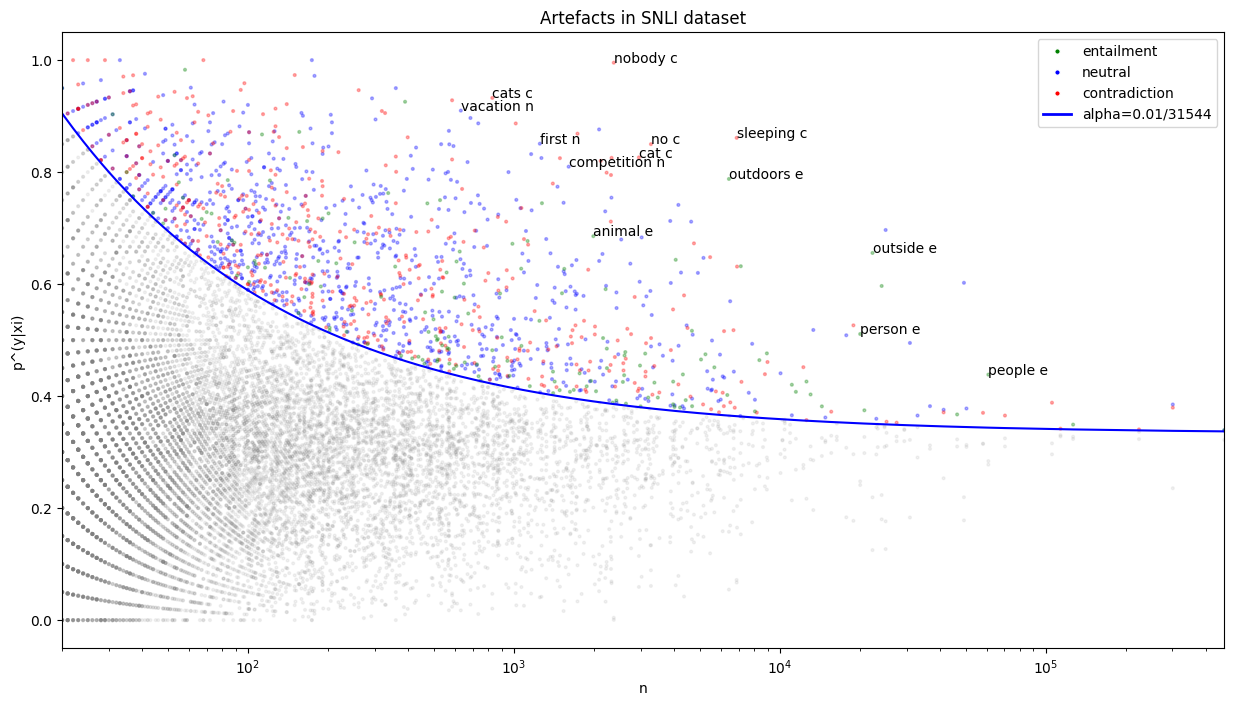

In [81]:
# Define the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15,8))

# Define a dictionary of colors for each label
colors = {'entailment': 'g', 'neutral': 'b', 'contradiction': 'r', 'grey': 'grey'}

# Define a dictionary of words to annotate in the plot for each label
token_label_annotate_dict = {
    'contradiction': ['nobody', 'cats', 'cat', 'no', 'sleeping'],
    'neutral': ['vacation', 'first', 'competition'],
    'entailment': ['outdoors', 'animal', 'outside', 'person', 'people']
}

# Plot the observed probabilities for each token and label
for label in labels:
    # Create a condition series to find which points are above the threshold
    is_above_threshold = token_df[f'{label}_prob'] > token_df['threshold']

    # Create a color and alpha series based on the condition series
    color_series = pd.Series(colors['grey'], index=token_df.index)
    color_series[is_above_threshold] = colors[label]

    alpha_series = pd.Series(0.1, index=token_df.index)
    alpha_series[is_above_threshold] = 0.3

    # Plot the points for this label
    ax.scatter(token_df['total_count'], token_df[f'{label}_prob'], c=color_series, alpha=alpha_series, s=4)

    # Add annotations for selected words
    for token in set(token_label_annotate_dict[label]) & set(token_df['token']):
        x = token_df.loc[token_df['token'] == token, 'total_count'].values[0]
        y = token_df.loc[token_df['token'] == token, f'{label}_prob'].values[0]
        ax.annotate(f'{token} {label[0]}', (x, y))

# Add the threshold line to the plot
ax.plot(token_df['total_count'].sort_values(), threshold, 'b-', label=f'alpha=0.01/{num_tests}')

# Adjust x-axis to be logarithmic and limit its range
ax.set_xscale('log')
ax.set_xlim([10**1.3, max(token_df['total_count'])])

# Hide the first x-axis label
ax.xaxis.get_major_ticks()[0].label1.set_visible(False)

# Set the labels for the x and y axes, and the title for the plot
ax.set_xlabel('n')
ax.set_ylabel('p^(y|xi)')
ax.set_title('Artefacts in SNLI dataset')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=4) for label, color in colors.items() if label != 'grey']
legend_elements.append(Line2D([0], [0], color='b', lw=2, label=f'alpha={alpha}/{num_tests}'))  # Add threshold line to legend
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot
plt.show()


In [ ]:
# plt.savefig('snli_artefacts_chart.png', bbox_inches='tight')

# Artefacts analysis

A simple cell to look into the statistics of token and label pairs

In [68]:
token_df

token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
1           person        20075           4976      0.247870   
2               is       224524          75480      0.336178   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
...            ...          ...            ...           ...   
31539  libertarian            1              1      1.000000   
31540      hospice            1              1      1.000000   
31541   prformance            1              1      1.000000   
31542    chilldren            1              0      0.000000   
31543     cleanest            1              0      0.000000   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
1                     4842            0.241196             10257   
2                    76463            0.340556             72581   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
...                    ...                 ...               ...   
31539                    0            0.000000                 0   
31540                    0            0.000000                 0   
31541                    0            0.000000                 0   
31542                    0            0.000000                 1   
31543                    1            1.000000                 0   

       entailment_prob  threshold  neutral_z_stat  contradiction_z_stat  \
0             0.339119   0.337063        8.384543            -16.796937   
1             0.510934   0.351377      -25.686882            -27.693124   
2             0.323266   0.338729        2.859230              7.259997   
3             0.160584   0.459437       16.637286             -9.208057   
4             0.183255   0.347880       60.251935             -4.301123   
...                ...        ...             ...                   ...   
31539         0.000000   1.000000        1.414214             -0.707107   
31540         0.000000   1.000000        1.414214             -0.707107   
31541         0.000000   1.000000        1.414214             -0.707107   
31542         1.000000   1.000000       -0.707107             -0.707107   
31543         0.000000   1.000000       -0.707107              1.414214   

       entailment_z_stat  
0               8.412395  
1              53.380006  
2             -10.119228  
3              -7.429228  
4             -55.950812  
...                  ...  
31539          -0.707107  
31540          -0.707107  
31541          -0.707107  
31542           1.414214  
31543          -0.707107  

[31544 rows x 12 columns]

In [71]:
token = 'nobody'
label = 'contradiction'

print(f"Total count : {token_df[token_df['token']==token]['total_count'].iloc[0]}")
print(f"{label} count for {token} : {token_df[token_df['token']==token][f'{label}_count'].iloc[0]}")
print(f"{label} Prob for {token} : {token_df[token_df['token']==token][f'{label}_prob'].iloc[0]}")
print(f"Z stat for {token} : {token_df[token_df['token']==token][f'{label}_z_stat'].iloc[0]}")
print(f"Threshold for the given token \"{token}\" : {token_df[token_df['token']==token]['threshold'].iloc[0]}")


Total count : 2377
contradiction count for nobody : 2366
contradiction Prob for nobody : 0.9953723180479596
Z stat for nobody : 68.47064385747095
Threshold for the given token "nobody" : 0.38576992850410563


In [16]:
# Create a list to store DataFrames of tokens that are considered artefacts for each label
artefact_dfs = []

# Iterate over all labels
for label in labels:
    # For each label, filter the DataFrame to only include rows where
    # the observed probability is greater than the threshold
    # These tokens are considered artefacts for the current label
    # Append the resulting DataFrame to the list
    artefact_dfs.append(token_df[token_df[f'{label}_prob'] > token_df['threshold']])

# Concatenate all the DataFrames in the list into a single DataFrame
# This DataFrame contains all tokens that are considered artefacts for any label
artefacts_df = pd.concat(artefact_dfs)

# Display the DataFrame
artefacts_df


token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
6              for        25031          17438      0.696656   
7      competition         1608           1302      0.809701   
...            ...          ...            ...           ...   
7517         folks          106             20      0.188679   
8013        liquid          116             23      0.198276   
9929          bvoy           20              1      0.050000   
10822    consuming           53              5      0.094340   
12228       sitted           35              3      0.085714   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
6                     4417            0.176461              3176   
7                      131            0.081468               175   
...                    ...                 ...               ...   
7517                    18            0.169811                68   
8013                    20            0.172414                73   
9929                     0            0.000000                19   
10822                    4            0.075472                44   
12228                    4            0.114286                28   

       entailment_prob  neutral_z_stat  contradiction_z_stat  \
0             0.339119        8.384543            -16.796937   
3             0.160584       16.637286             -9.208057   
4             0.183255       60.251935             -4.301123   
6             0.126883      121.937707            -52.649129   
7             0.108831       40.522106            -21.424873   
...                ...             ...                   ...   
7517          0.641509       -3.159293             -3.571375   
8013          0.629310       -3.085701             -3.676580   
9929          0.950000       -2.687936             -3.162278   
10822         0.830189       -3.690886             -3.982272   
12228         0.800000       -3.107594             -2.749026   

       entailment_z_stat  threshold  
0               8.412395   0.337063  
3              -7.429228   0.459437  
4             -55.950812   0.347880  
6             -69.288578   0.349492  
7             -19.097233   0.397087  
...                  ...        ...  
7517            6.730668   0.581644  
8013            6.762281   0.570700  
9929            5.850214   0.904988  
10822           7.673158   0.684498  
12228           5.856620   0.765464  

[1508 rows x 12 columns]

In [72]:
# Add a new column that indicates which labels a token is significantly correlated with
artefacts_df["correlated_to"] = artefacts_df.apply(
    lambda row: [label for label in labels if row[f'{label}_prob'] > row['threshold']], axis=1
    )

# Display the updated DataFrame
artefacts_df


token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
6              for        25031          17438      0.696656   
7      competition         1608           1302      0.809701   
...            ...          ...            ...           ...   
7517         folks          106             20      0.188679   
8013        liquid          116             23      0.198276   
9929          bvoy           20              1      0.050000   
10822    consuming           53              5      0.094340   
12228       sitted           35              3      0.085714   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
6                     4417            0.176461              3176   
7                      131            0.081468               175   
...                    ...                 ...               ...   
7517                    18            0.169811                68   
8013                    20            0.172414                73   
9929                     0            0.000000                19   
10822                    4            0.075472                44   
12228                    4            0.114286                28   

       entailment_prob  neutral_z_stat  contradiction_z_stat  \
0             0.339119        8.384543            -16.796937   
3             0.160584       16.637286             -9.208057   
4             0.183255       60.251935             -4.301123   
6             0.126883      121.937707            -52.649129   
7             0.108831       40.522106            -21.424873   
...                ...             ...                   ...   
7517          0.641509       -3.159293             -3.571375   
8013          0.629310       -3.085701             -3.676580   
9929          0.950000       -2.687936             -3.162278   
10822         0.830189       -3.690886             -3.982272   
12228         0.800000       -3.107594             -2.749026   

       entailment_z_stat  threshold          correlated_to  \
0               8.412395   0.337063  [neutral, entailment]   
3              -7.429228   0.459437              [neutral]   
4             -55.950812   0.347880              [neutral]   
6             -69.288578   0.349492              [neutral]   
7             -19.097233   0.397087              [neutral]   
...                  ...        ...                    ...   
7517            6.730668   0.581644           [entailment]   
8013            6.762281   0.570700           [entailment]   
9929            5.850214   0.904988           [entailment]   
10822           7.673158   0.684498           [entailment]   
12228           5.856620   0.765464           [entailment]   

       num_correlated_labels  
0                          2  
3                          1  
4                          1  
6                          1  
7                          1  
...                      ...  
7517                       1  
8013                       1  
9929                       1  
10822                      1  
12228                      1  

[1508 rows x 14 columns]

In [73]:
# Add a column to get the number of correlated labels for each token
artefacts_df['num_correlated_labels'] = artefacts_df['correlated_to'].apply(lambda x: len(x))

# Display Dataframe
artefacts_df

token  total_count  neutral_count  neutral_prob  \
0                a       469871         159333      0.339099   
3         training          411            296      0.720195   
4              his        30886          15287      0.494949   
6              for        25031          17438      0.696656   
7      competition         1608           1302      0.809701   
...            ...          ...            ...           ...   
7517         folks          106             20      0.188679   
8013        liquid          116             23      0.198276   
9929          bvoy           20              1      0.050000   
10822    consuming           53              5      0.094340   
12228       sitted           35              3      0.085714   

       contradiction_count  contradiction_prob  entailment_count  \
0                   151196            0.321782            159342   
3                       49            0.119221                66   
4                     9939            0.321796              5660   
6                     4417            0.176461              3176   
7                      131            0.081468               175   
...                    ...                 ...               ...   
7517                    18            0.169811                68   
8013                    20            0.172414                73   
9929                     0            0.000000                19   
10822                    4            0.075472                44   
12228                    4            0.114286                28   

       entailment_prob  neutral_z_stat  contradiction_z_stat  \
0             0.339119        8.384543            -16.796937   
3             0.160584       16.637286             -9.208057   
4             0.183255       60.251935             -4.301123   
6             0.126883      121.937707            -52.649129   
7             0.108831       40.522106            -21.424873   
...                ...             ...                   ...   
7517          0.641509       -3.159293             -3.571375   
8013          0.629310       -3.085701             -3.676580   
9929          0.950000       -2.687936             -3.162278   
10822         0.830189       -3.690886             -3.982272   
12228         0.800000       -3.107594             -2.749026   

       entailment_z_stat  threshold          correlated_to  \
0               8.412395   0.337063  [neutral, entailment]   
3              -7.429228   0.459437              [neutral]   
4             -55.950812   0.347880              [neutral]   
6             -69.288578   0.349492              [neutral]   
7             -19.097233   0.397087              [neutral]   
...                  ...        ...                    ...   
7517            6.730668   0.581644           [entailment]   
8013            6.762281   0.570700           [entailment]   
9929            5.850214   0.904988           [entailment]   
10822           7.673158   0.684498           [entailment]   
12228           5.856620   0.765464           [entailment]   

       num_correlated_labels  
0                          2  
3                          1  
4                          1  
6                          1  
7                          1  
...                      ...  
7517                       1  
8013                       1  
9929                       1  
10822                      1  
12228                      1  

[1508 rows x 14 columns]

In [76]:
one_label = artefacts_df[artefacts_df['num_correlated_labels']==1].shape[0]
print(f"Tokens correlated with 1 label: {one_label}")
two_labels = artefacts_df[artefacts_df['num_correlated_labels']==2].shape[0]
print(f"Tokens correlated with 2 labels: {two_labels}")

Tokens correlated with 1 label: 1472
Tokens correlated with 2 labels: 36
